# Sampling with Space Partitioning

## Tutorial Notebook 

    Structure: 
    
    1. BAT model definition: Gaussian mixture
    2. Single-click run: Default settings  
    3. Detailed sampling summary
       -- @elapsed/@CPUelapsed time 
       -- Posterior integrals
       -- Plotting
    4. Fine-grained control: Samplers, integrators, partitioner 
       -- HMC/Sobol


In [1]:
using IntervalSets
using Distributions
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2
using ValueShapes
using TypedTables
using Measurements
using TypedTables
using HypothesisTests

┌ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1278


In [2]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
using BAT

## 1. BAT model definition: Gaussian mixture

Let us use a mixture of 4 normal distribution with random  covariance matrices as a model: 

In [4]:
σ_1 = [3.426818298733095 12.378238116671048 -9.632531611142454; 3.426818298733095 4.916266580684483 -5.029942800849483; 3.426818298733095 -6.737309268887753 5.4343957706004415; 3.426818298733095 -3.9729587574454333 3.379361860370276]
σ_2 = [12.378238116671048 69.83909693165143 -43.478993858310886; 4.916266580684482 69.83909693165143 -64.18784570966332; -6.737309268887753 69.83909693165143 32.734776615550174; -3.972958757445433 69.83909693165143 53.74871853095418]
σ_3 = [-9.632531611142456 -43.478993858310886 60.0626256206892; -5.029942800849484 -64.18784570966332 60.0626256206892; 5.4343957706004415 32.734776615550174 60.0626256206892; 3.3793618603702757 53.74871853095418 60.0626256206892]
σ = cat(σ_1,σ_2,σ_3, dims=3)

μ = [8.959570984309234 -9.021529871694005 -5.007789383392622; -1.446445514344754 -7.8327010768703875 -3.2653263028963986; -6.40954093270941 0.25815094665222027 5.830143596540282; 5.076504517881521 -0.8952973253675331 9.16356325348496]

mixture_model = MixtureModel(MvNormal[MvNormal(μ[i,:], Matrix(Hermitian(σ[i,:,:])) ) for i in 1:4]);


In [5]:
prior = NamedTupleDist(a = [Uniform(-50,50), Uniform(-50,50), Uniform(-50,50)])

likelihood = let model = mixture_model
    params -> LogDVal(logpdf(model, params.a))
end

posterior = PosteriorDensity(likelihood, prior);

log_volume = BAT.log_volume(BAT.spatialvolume(posterior.parbounds))

13.815510557964275

## 2. Single-click run: Default settings 

Default parameters of the `PartitionedSampling()` algorithm: 

1) Exploration samples: `MetropolisHastings()` sampler (20 chains * 10^2 samples)

2) Sampling: `MetropolisHastings()` sampler

3) Space partitioning: `KDTreePartitioning()`

4) Reweighting: `AHMIntegration()`


In [6]:
n_samples = 5*10^5 

500000

To generate samples with default settings

In [10]:
mcmc = MCMCSampling(mcalg = MetropolisHastings(), nsteps = 10^5, trafo = NoDensityTransform(),)

mcmc_exp = MCMCSampling(mcalg = MetropolisHastings(), nsteps = 1000, nchains=20, trafo = NoDensityTransform())

algorithm_1 = PartitionedSampling(sampler = mcmc, npartitions=15, exploration_sampler=mcmc_exp)

output_sp = bat_sample(posterior, algorithm_1)

samples_1 = output_sp.result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Generating Exploration Samples
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/partitioned_sampling/partition_sample.jl:40
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm DensityIdentityTransform()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 20 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 20 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 20 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCM

Just to compare, let us generate samples using MetropolisHastings algorithm, too:

In [11]:
algorithm_2 = MCMCSampling()

output_mcmc = bat_sample(posterior, algorithm_2)

samples_2 = output_mcmc.result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm PriorSubstitution()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_bur

Standard BAT statistics on the posterior DensitySampleVector:

In [12]:
println("Mode: $(mode(samples_1))")
println("Mode: $(mode(samples_2))")

println("Mean: $(mean(samples_1))")
println("Mean: $(mean(samples_2))")

Mode: ShapedAsNT((a = [-1.503148446226827, -7.947169801124773, -3.1602899018522246],))
Mode: ShapedAsNT((a = [-1.5195547158893987, -8.101403928172424, -3.1173512482046632],))
Mean: ShapedAsNT((a = [1.5531004233135386, -4.380285880676797, 1.6761337038511994],))
Mean: ShapedAsNT((a = [1.7192701450342582, -4.337034775360511, 1.6339891446377461],))


Standard BAT plotting recipes: 

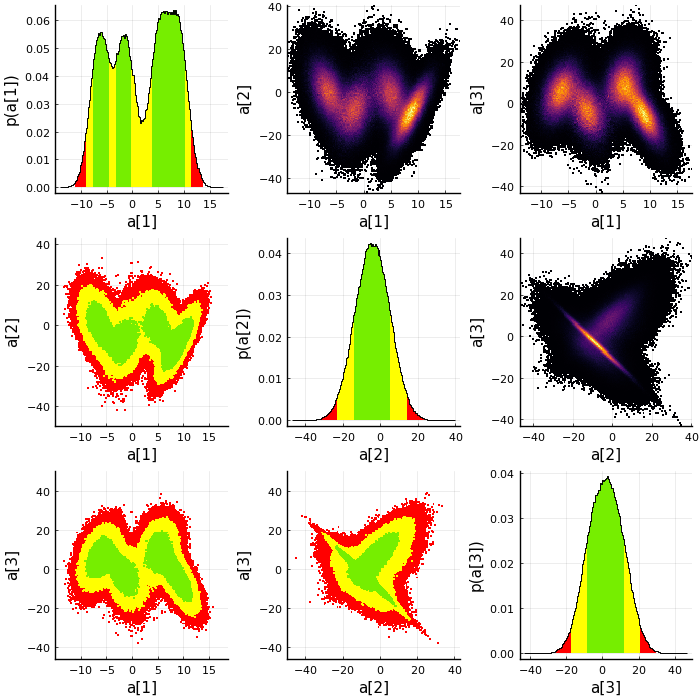

In [13]:
plot(samples_1, size=(700,700), upper=Dict("mean"=>false, "globalmode"=>false, "localmode"=>false))

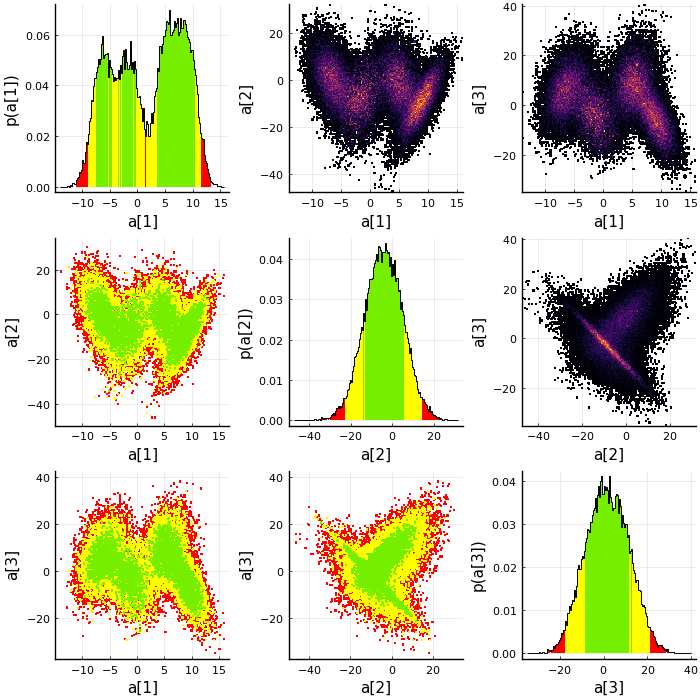

In [14]:
plot(samples_2, size=(700,700), upper=Dict("mean"=>false, "globalmode"=>false, "localmode"=>false))

## 3. Detailed sampling summary

Run information:

In [15]:
columnnames(output_sp.info)

(:density_integral, :sampling_cpu_time, :integration_cpu_time, :sampling_wc, :integration_wc, :worker_id, :n_threads, :samples_ind, :sum_weights)

In [16]:
output_sp.info

Table with 9 columns and 15 rows:
      density_integral  sampling_cpu_time  integration_cpu_time  ⋯
    ┌─────────────────────────────────────────────────────────────
 1  │ 6.623e-8±2.2e-10  8.45126            7.29265               ⋯
 2  │ 6.884e-8±4.4e-10  6.0205             2.10077               ⋯
 3  │ 1.059e-7±1.0e-9   5.59573            1.36328               ⋯
 4  │ 6.327e-8±6.9e-10  7.08847            1.51706               ⋯
 5  │ 9.82e-8±1.5e-9    7.78342            1.43081               ⋯
 6  │ 7.447e-8±4.8e-10  5.71235            1.69772               ⋯
 7  │ 3.993e-8±2.4e-10  6.60032            1.88587               ⋯
 8  │ 5.289e-8±2.5e-10  5.17451            1.86149               ⋯
 9  │ 6.448e-8±3.3e-10  5.55068            2.06758               ⋯
 10 │ 6.484e-8±5.1e-10  6.28711            1.73021               ⋯
 11 │ 5.946e-8±4.3e-10  5.8519             1.66235               ⋯
 12 │ 3.658e-8±2.3e-10  5.98235            1.754                 ⋯
 13 │ 7.13e-8±4.9e-10   5.45

In [17]:
posterior_integral = sum(output_sp.info.density_integral)

9.988e-7 ± 2.4e-9

In [18]:
log(posterior_integral)

-13.8167 ± 0.0024

In [19]:
total_cpu_time = sum(output_sp.info.sampling_cpu_time) + sum(output_sp.info.integration_cpu_time)

124.20701199999999

In [20]:
total_wc_time = (output_sp.info.sampling_wc[end][end] - output_sp.info.sampling_wc[1][1])*1e-9

42.644000000000005

Partition tree: 

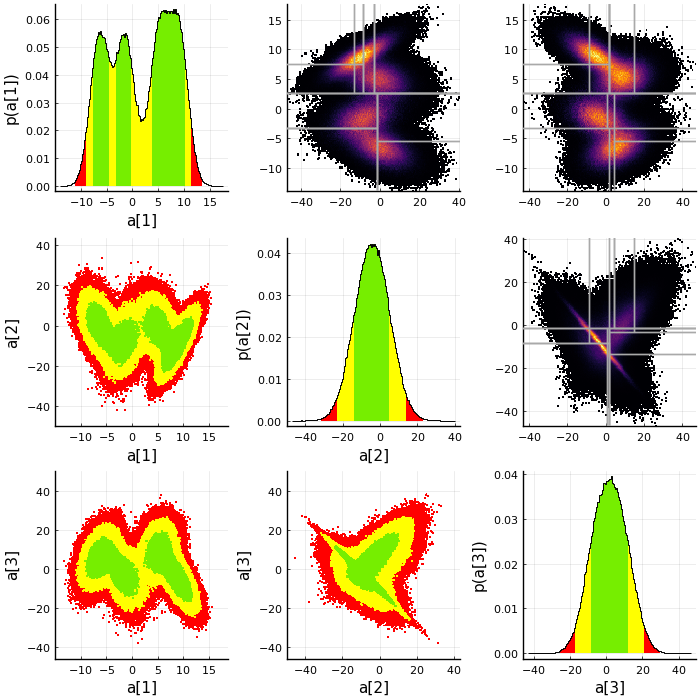

In [21]:
plot(samples_1, size=(700,700), upper=Dict("partition_tree"=>output_sp.part_tree, "mean"=>false, "globalmode"=>false, "localmode"=>false))

Exploration samples: 

In [22]:
n_explorstion = length(output_sp.exp_samples)

3493

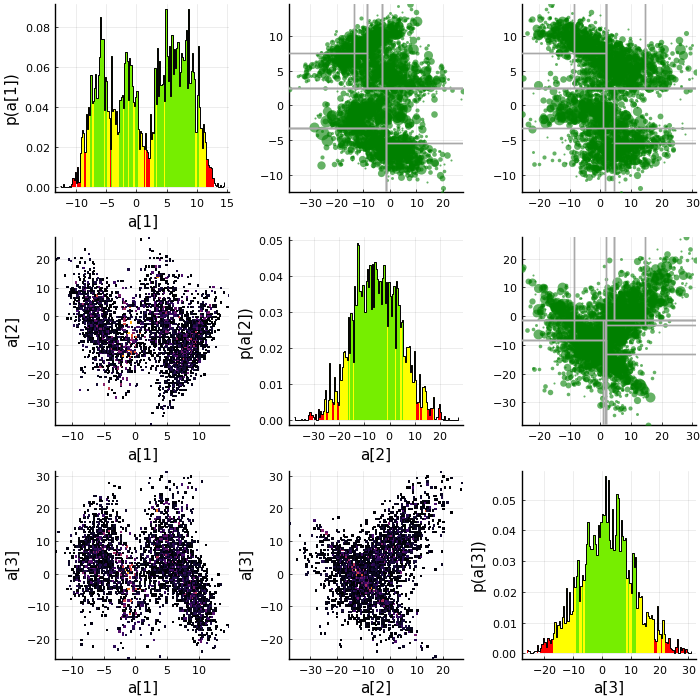

In [23]:
plot(output_sp.exp_samples, size=(700,700), 
    upper = Dict("seriestype"=>:scatter, "colors"=>:red, "partition_tree"=>output_sp.part_tree,), 
    lower = Dict("seriestype"=>:hist, "bins"=>30),
    diagonal = Dict("bins"=>30),)

## 4. Fine-grained control: Samplers, integrators, partitioner 

Subspace sampler can be any `BAT.AbstractSamplingAlgorithm` algorithm: 

In [30]:
tuning_1 = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

sampler = MetropolisHastings(
    weighting = RepetitionWeighting(),
    tuning = tuning_1
)

init_1 = MCMCChainPoolInit(
    init_tries_per_chain = 50 .. 150,
    nsteps_init = 1500
)

burnin_1 = MCMCMultiCycleBurnin(
    max_ncycles = 160,
    nsteps_per_cycle = 40000
)

sampling_alg = MCMCSampling(mcalg=sampler, init=init_1, burnin=burnin_1, strict=false, nchains = 4, nsteps = 10^5, trafo = NoDensityTransform(),);

The same with exploration sampler

In [32]:
burnin_2 = MCMCMultiCycleBurnin(
    max_ncycles = 40,
    nsteps_per_cycle = 4000
)

exploration_alg = MCMCSampling(mcalg=MetropolisHastings(), nsteps = 10^2,  nchains=50, burnin=burnin_2);

Space partitioning can be done using `BAT.KDTreePartitioning` algorithm

In [33]:
partitioner = BAT.KDTreePartitioning(
        partition_dims = [1,2,], # dimension indices that are considered for partition
        extend_bounds=false # "false" is appropriate for debugging, very fast tuning /convergence 
    );

n_partitions = 17

17

To integrate subspaces, any `BAT.IntegrationAlgorithm` can be used: 

In [34]:
integrator = AHMIntegration(  
        whitening= CholeskyPartialWhitening(),
        autocorlen= GeyerAutocorLen(),
        volumetype = :HyperRectangle,
        max_startingIDs = 10000,
        max_startingIDs_fraction = 2.5,
        rect_increase = 0.1,
        warning_minstartingids = 16,
        dotrimming = true,
        uncertainty= [:cov]
    );

Finally, `PartitionedSampling` can be defined using settings: 

In [36]:
algorithm = PartitionedSampling(
        sampler = sampling_alg,
        exploration_sampler = exploration_alg,
        partitioner = partitioner,
        integrator = integrator,
        npartitions = n_partitions
    );

In [38]:
output_sp_ms = bat_sample(posterior, algorithm);

samples_3 = output_sp_ms.result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Generating Exploration Samples
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/partitioned_sampling/partition_sample.jl:40
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Using tranform algorithm PriorSubstitution()
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 50 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 50 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 50 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tunin

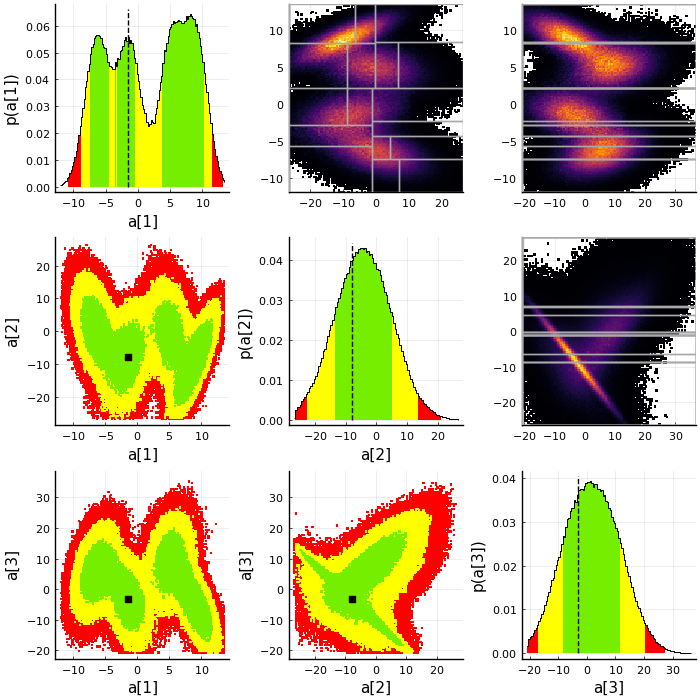

In [39]:
plot(samples_3, vsel=[1,2,3], size=(700,700), globalmode=true, localmode=true, 
    upper=Dict("partition_tree"=>output_sp_ms.part_tree, 
        "mean"=>false, "globalmode"=>false, "localmode"=>false))

In [40]:
posterior_integral = sum(output_sp_ms.info.density_integral)

9.824e-7 ± 2.4e-9

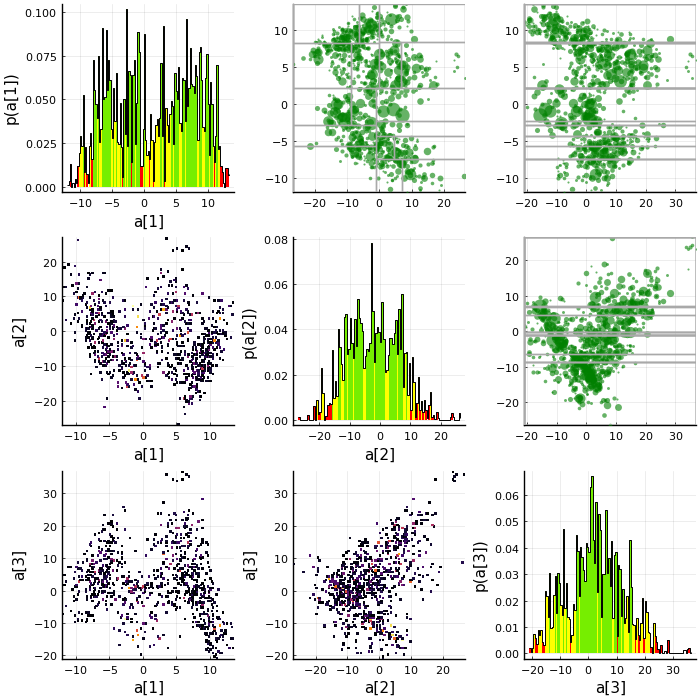

In [41]:
plot(output_sp_ms.exp_samples, size=(700,700), 
    upper = Dict("seriestype"=>:scatter, "partition_tree"=>output_sp_ms.part_tree,), 
    lower = Dict("seriestype"=>:hist, "bins"=>30),
    diagonal = Dict("bins"=>30),)